# 02: Monte Carlo Integration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
try: plt.style.use('./mc_notebook.mplstyle')
except: pass

We have just seen that any integral can be sampled:

\begin{align*}
I = \frac{\int_{\Omega} d^d x\, f(x_1,\ldots,x_d)}{\int_\Omega d^d x\,} & = \int_\Omega d^d x\, \pi(x_1,\ldots,x_d) \, f(x_1,\ldots,x_d)
= \langle f \rangle \newline
&\simeq \frac{1}{N} \sum_n f(\mathbf{x}_n)
\end{align*}

where $\mathbf{x}_n \in \mathcal{U}_\Omega$ with $\mathcal{U}_\Omega$ the uniform probability distribution over the d-dimensional hypercubic region $\Omega$.

It is natural to ask if such sampling methods are better than standard **Newton-Cotes** quadrature methods where the function to be integrated is broken up into $N$ panels:

### Rectangular

\begin{equation}
\int_a^b f(x) dx = \frac{b-a}{N} \sum_{j=0}^{N-1} f\left(a + \frac{j(b-a)}{N}\right) + \mathrm{O}\left(\frac{1}{N}\right). 
\end{equation}

### Trapezoidal

\begin{equation}
\int_a^b f(x) dx = \frac{b-a}{N}\left [\frac{1}{2}f(a) +  \sum_{j=1}^{N-1} f\left(a + \frac{j(b-a)}{N}\right) +\frac{1}{2}f(b)\right] + \mathrm{O}\left(\frac{1}{N^2}\right). 
\end{equation}

### Simpson

\begin{equation}
\int_a^b f(x) dx = \frac{b-a}{3N}\left \{ f(a) +  \sum_{j=1}^{N-1}\left[3-(-1)^j\right] f\left(a + \frac{j(b-a)}{N}\right) +f(b)\right\} + \mathrm{O}\left(\frac{1}{N^4}\right). 
\end{equation}

In [2]:
def quadrature(f,x,*params,method='simpson'):
    '''Newton-Cotes methods for numerical integration of f(x) over x.'''
    a,b = x[0],x[-1]
    Δx = x[1] - x[0]
    N = x.size
    
    if method == 'rectangular':
        I = np.sum([f(a+j*Δx,*params) for j in range(N-1)])
    if method == 'trapezoidal':
        I = 0.5*(f(a,*params)+f(b,*params)) 
        I += np.sum([f(a+j*Δx,*params) for j in range(1,N-1)])
    elif method == 'simpson':
        I = (f(a,*params) + f(b,*params))/3.0
        I += (4.0/3.0)*np.sum([f(a+j*Δx,*params) for j in range(1,N,2)])
        I += (2.0/3.0)*np.sum([f(a+j*Δx,*params) for j in range(2,N-1,2)])
        
    return Δx*I

Let's use Simpson's rule to evaluate the $\mathrm{erf}(1/2)$ where 

\begin{equation}
\mathrm{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x \mathrm{e}^{-t^2} dt 
\end{equation}

In [4]:
from numpy import pi as π
def erf_kernel(t):
    '''The error function kernel.'''
    return  (2.0/np.sqrt(π))*np.exp(-t*t)

import scipy.special

In [5]:
# note: want an odd number of points for Simpson's method
x = np.linspace(0,0.5,2**16+1)
print('Simpson: erf(1/2) = %18.16f'% quadrature(erf_kernel,x))
print('Scipy:   erf(1/2) = %18.16f'% scipy.special.erf(0.5))

Simpson: erf(1/2) = 0.5204998778130465
Scipy:   erf(1/2) = 0.5204998778130465


## Newton-Cotes Error Scaling

These methods work very well in 1 dimension but how do they scale in higher dimension?

\begin{equation}
I = \int_{\Omega} d^d x\, f(\mathbf{x}) = \int dx_1 \int dx_2 \cdots \int dx_d\, f(\mathbf{x}).
\end{equation}

We will need to break up $d$-dimensional space into a grid with $N$ panels in each dimension which will form $M = N^d$ total points at which we must evaulate our function.  If we say a quadrature method is $k^{th}$ order then the error scales as $N^{-k}$ (i.e. Simpson's method is $4^{\rm th}$ order) then using this method in $d$ dimensions will lead to an error:

\begin{equation}
\mathrm{Error} \sim \frac{1}{N^k} = \frac{1}{M^{k/d}}.
\end{equation}

<div class="span alert alert-danger">
**This is bad!  An order $k$-scheme in 1-dimension is an order $k/d$ scheme in $d$-dimensions.**
</div>

## High Dimensional Integrals with Monte Carlo Sampling

It is trivial to extend our Monte Carlo sampling approach to compute the $d$-dimensional integral of a function $f(\mathbf{x})$ .  Consider:

\begin{equation}
I = \int_{-1/2}^{1/2} dx \int_{-1/2}^{1/2} dx \, \sqrt{1+x^2+y^2} \mathrm{e}^{-x^2-y^2}
\end{equation}

where we have chosen the region of integration such that the the uniform distribution is $\pi(x,y) = 1$.

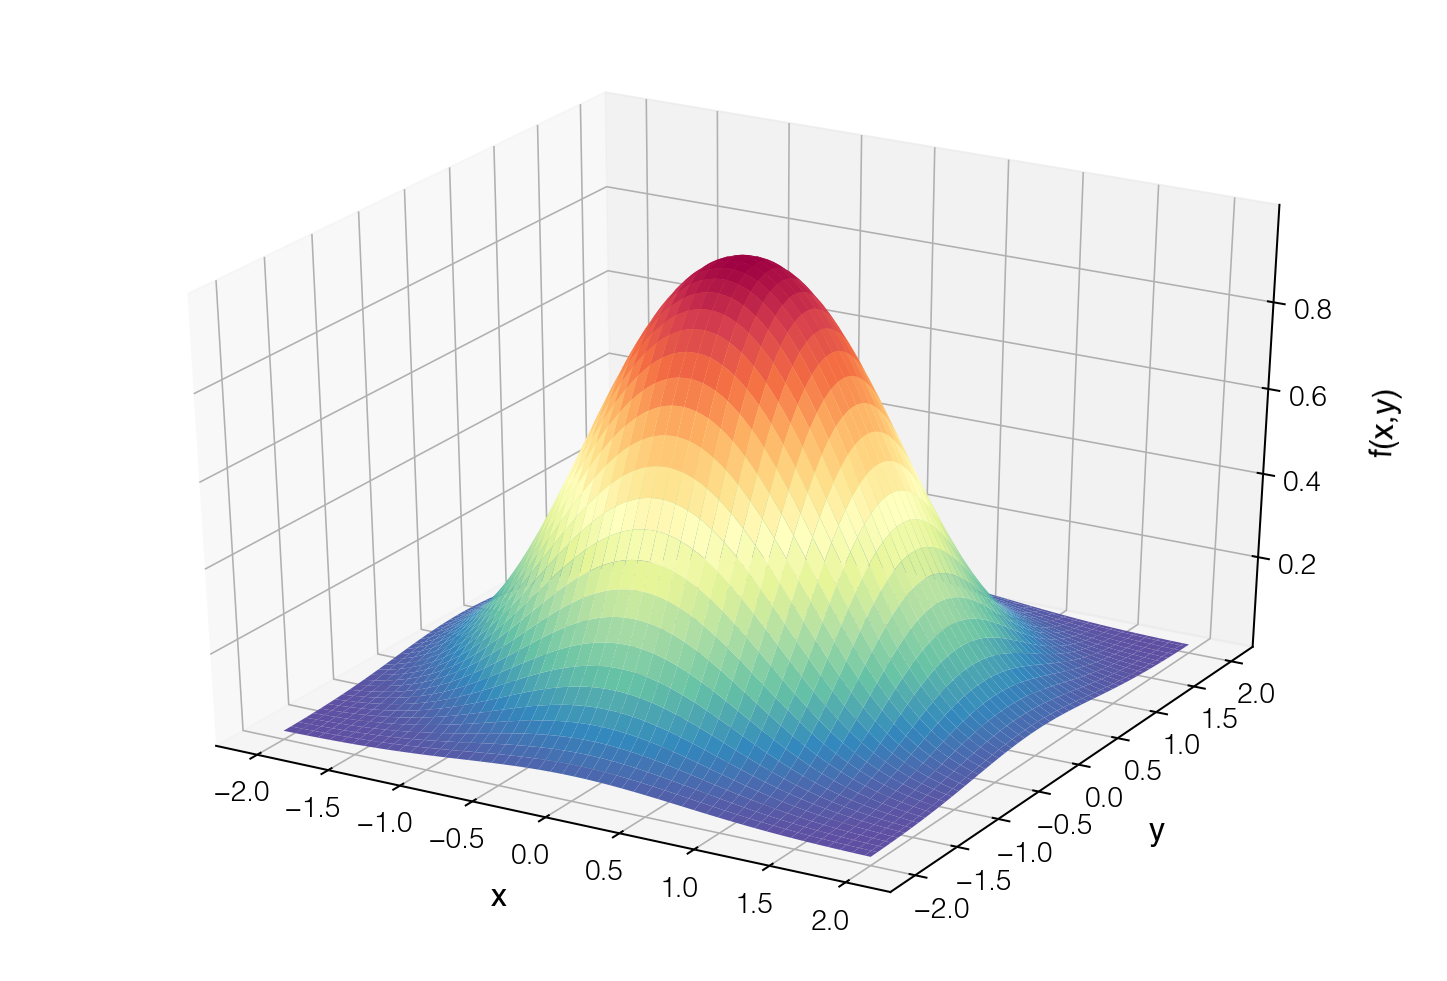

In [6]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
f = np.exp(-X**2 - Y**2)*np.sqrt(1+X**2+Y**2)
surf = ax.plot_surface(X, Y, f, rstride=2, cstride=2, cmap='Spectral_r', linewidth=0, antialiased=True)

ax.set_xlabel('x',labelpad=14)
ax.set_ylabel('y',labelpad=14)
ax.set_zlabel('f(x,y)',labelpad=14)

[t.label.set_fontsize(14) for caxis in [ax.xaxis, ax.yaxis, ax.zaxis] for t in caxis.get_major_ticks()];

### Monte Carlo Sample the Integral

In [7]:
def f(x,y):
    return np.exp(-x**2 - y**2)*np.sqrt(1+x**2+y**2)

# Number of MC points
N = 2**16

# initialize
I = 0

# Monte Carlo Sampling
for n in range(N):
    x = np.random.uniform(-0.5,0.5)
    y = np.random.uniform(-0.5,0.5)
    I += f(x,y)
    
I /= N

print('I ≃ %12.10f' % I)

I ≃ 0.9140973104


The exact answer to double precision is:

In [9]:
I_exact = 0.9141469594691902

## Computing the Error

The error in computing the integral is now stochastic (as opposed to systematic).  It can be estimated via the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem):


\begin{equation}
\boxed{
\mathrm{Error}  =  \frac{\sigma_f}{\sqrt{N}}
}
\end{equation}

where 

\begin{equation}
\boxed{
\sigma_f^2 = \langle f^2 \rangle - \langle f \rangle^2
}
\end{equation}

is the variance of $f$ over the region (which can be estimated via sampling).  Thus the total error scales as:

\begin{equation}
\mathrm{O}\left(\frac{1}{N^{1/2}}\right).
\end{equation}

and recall that we found for $d$-dimensions, Simpson's rule had an $\mathrm{O}\left(N^{-4/d}\right)$ error, thus **Monte Carlo beats Simpson's rule for d > 8**.

However, this error estimate relies on perfect direct sampling, i.e. the ability to sample wihout correlations.  

Let's investigate this for our integral:

### Direct Sampling (all samples uncorrelated)

In [10]:
f_direct = np.zeros(N)

for n in range(N):
    x = np.random.uniform(-0.5,0.5)
    y = np.random.uniform(-0.5,0.5)
    f_direct[n] = f(x,y)

I_direct = np.average(f_direct)
ΔI_direct = np.std(f_direct)/np.sqrt(N)
δ_direct = np.abs(I_direct - I_exact)/ΔI_direct

print('I = %12.10f ± %8.6f' % (I_direct,ΔI_direct))
print('|I-I_exact|/ΔI = %4.2fσ' % (δ_direct))
print('Likelihood     = %5.2f '% (1-scipy.special.erf(δ_direct/np.sqrt(2))))

I = 0.9140258373 ± 0.000214
|I-I_exact|/ΔI = 0.57σ
Likelihood     =  0.57 


### Markov Chain Sampling (possible correlations between samples)

In [11]:
f_markov_chain = np.zeros(N)
x = np.zeros(N)
y = np.zeros(N)

# the update size
δ = 0.1

f_markov_chain[0] = f(x[0],y[0])

for n in range(1,N):
    Δx = np.random.uniform(-δ,δ)
    Δy = np.random.uniform(-δ,δ)
    
    # update only if the new position is inside the square
    x[n] = x[n-1] + Δx*(np.abs(x[n-1]+Δx) < 0.5)
    y[n] = y[n-1] + Δy*(np.abs(y[n-1]+Δy) < 0.5)
    
    f_markov_chain[n] = f(x[n],y[n])

I_markov_chain = np.average(f_markov_chain)
ΔI_markov_chain = np.std(f_markov_chain)/np.sqrt(N)
δ_markov_chain = np.abs(I_markov_chain - I_exact)/ΔI_markov_chain

print('I ≃ %12.10f ± %8.6f' % (I_markov_chain,ΔI_markov_chain))
print('|I-I_exact|/ΔI = %4.2fσ' % δ_markov_chain)
print('Likelihood     = %5.2f '% (1-scipy.special.erf(δ_markov_chain/np.sqrt(2))))

I ≃ 0.9133018781 ± 0.000215
|I-I_exact|/ΔI = 3.94σ
Likelihood     =  0.00 


## Binning Analysis 

We can get a more accurate estimation for the error by combining or *binning* data into a hierachy of averages where correlations are removed at each level.  We may then investigate the error as a funtion of level.

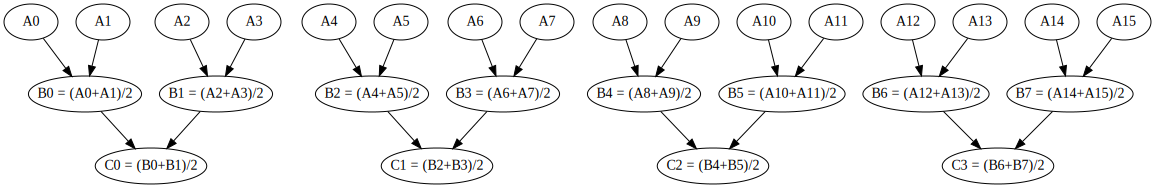

In [12]:
from IPython.display import display

try:
    import graphviz
    bins = graphviz.Digraph()
    for i in range(2**4):
        bins.node(name="A%d"%i)

    for i in range(2**3):
        bins.node(name="B%d"%i, label='B%d = (A%d+A%d)/2'%((i,2*i,2*i+1)))
    for i in range(2**2):
        bins.node(name="C%d"%i, label='C%d = (B%d+B%d)/2'%((i,2*i,2*i+1)))

    for i in range(2**3):
        for j in range(2):
            bins.edge("A%d"%(2*i+j), "B%d"%i)

    for i in range(2**2):
        for j in range(2):
            bins.edge("B%d"%(2*i+j), "C%d"%i)
    display(bins)
    
except:
    pass


In [13]:
def get_binned_error(mc_data):
    '''Get the standard error in mc_data and return neighbor averaged data.'''
    N_bins = mc_data.size
    Δ = np.std(mc_data)/np.sqrt(N_bins)
    
    start_bin = N_bins % 2
    binned_mc_data = 0.5*(mc_data[start_bin::2]+mc_data[start_bin+1::2])
   
    return Δ,binned_mc_data

In [14]:
# number of possible binning levels
num_levels = np.int(np.log2(f_markov_chain.size/4))+1

# compute the error at each bin level
Δ = []
binned_mc_data = f_markov_chain

for n in range(num_levels):
    Δₙ,binned_mc_data = get_binned_error(binned_mc_data)
    Δ.append(Δₙ)

#### Plot the standard error as a function of bin level

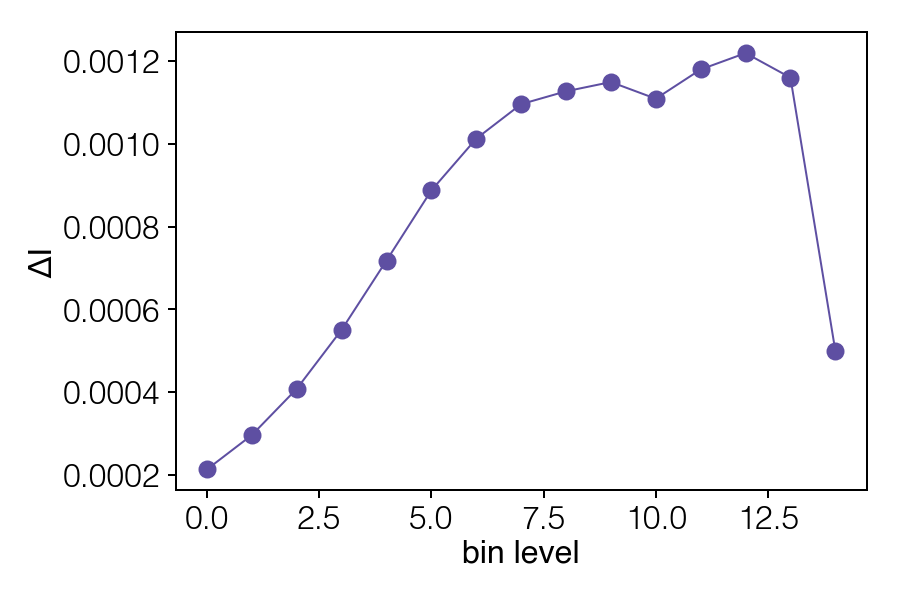

In [15]:
plt.plot(Δ,'-o', linewidth=1, markersize=8)
plt.xlabel('bin level')
plt.ylabel('ΔI');

In [16]:
ΔI_binning = Δ[9]
δ_binning = np.abs(I_markov_chain - I_exact)/ΔI_binning

print('I ≃ %12.10f ± %8.6f' % (I_markov_chain,Δ[9]))
print('|I-I_exact|/ΔI = %4.2fσ' % δ_binning)
print('Likelihood     = %5.2f '% (1-scipy.special.erf(δ_binning/np.sqrt(2))))

I ≃ 0.9133018781 ± 0.001148
|I-I_exact|/ΔI = 0.74σ
Likelihood     =  0.46 


### Useful resources for leaning more about error analsys

* [V. Ambegaokar and M. Troyer, *Estimating Errors Reliably in Monte Carlo Simulations of the Ehrenfest Model*, Am. J. Phys. **78**, 150 (2010).](https://doi.org/10.1119/1.3247985)
* [P. Young, *Everything You Wanted to Know About Data Analysis and Fitting but Were Afraid to Ask*, arXiv:1210.3781 (2012).](https://arxiv.org/abs/1210.3781)


## Importance Sampling

Let's return to our 2D integral but now extend the region of integration out to $\pm 5$:

\begin{equation}
I = \frac{1}{100}\int_{-5}^{5} dx \int_{-5}^{5} dx \, \sqrt{1+x^2+y^2} \mathrm{e}^{-x^2-y^2}
\end{equation}

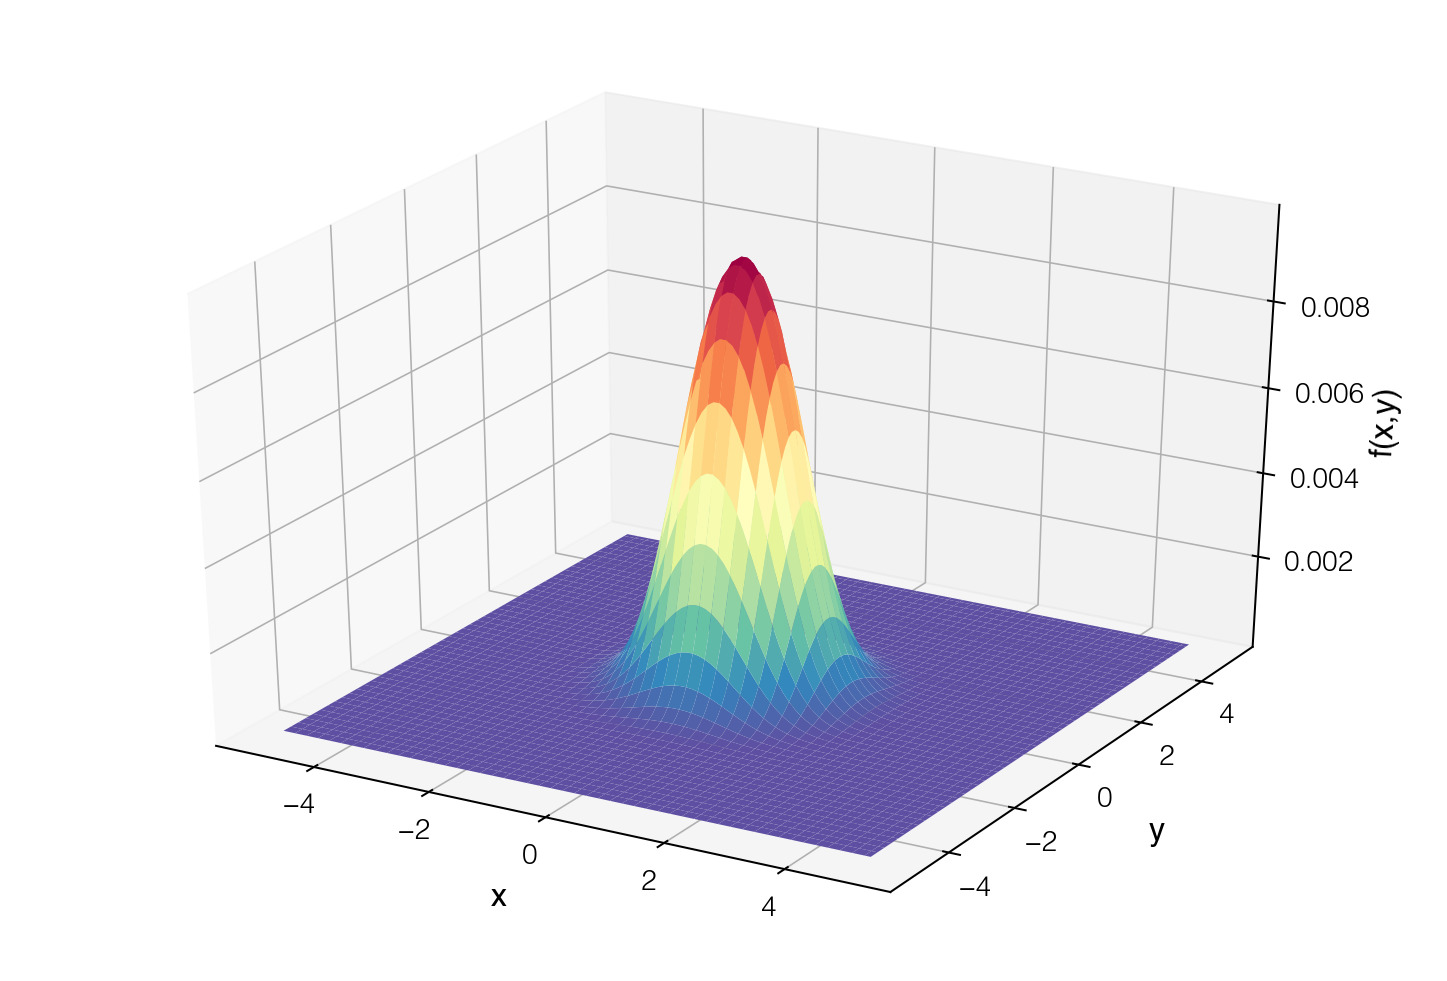

In [17]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
surf = ax.plot_surface(X, Y, np.exp(-X**2 - Y**2)*np.sqrt(1+X**2+Y**2)/100, rstride=2, cstride=2, 
                       cmap='Spectral_r', linewidth=0, antialiased=True)

ax.set_xlabel('x',labelpad=14)
ax.set_ylabel('y',labelpad=14)
ax.set_zlabel('f(x,y)',labelpad=14)
ax.tick_params(axis='z', which='major', pad=10)


[t.label.set_fontsize(14) for caxis in [ax.xaxis, ax.yaxis, ax.zaxis] for t in caxis.get_major_ticks()];

From this plot it is clear that uniform sampling over the entire region will be very ineffecient as the integrand is mostly zero.  This will lead to a large sampling error as the variance will be large.

In [18]:
N = 2**16
f_direct = np.zeros(N)

for n in range(N):
    x = np.random.uniform(-5,5)
    y = np.random.uniform(-5,5)
    f_direct[n] = f(x,y)

I_direct = np.average(f_direct)
ΔI_direct = np.std(f_direct)/np.sqrt(N)
δ_direct = np.abs(I_direct - 0.04332055352082126)/ΔI_direct
print('I = %12.10f ± %8.6f' % (I_direct,ΔI_direct))
print('|I-I_exact|/ΔI = %4.2fσ' % (δ_direct))
print('Likelihood     = %5.2f '% (1-scipy.special.erf(δ_direct/np.sqrt(2))))

I = 0.0438953020 ± 0.000582
|I-I_exact|/ΔI = 0.99σ
Likelihood     =  0.32 


**Note:** The error bar has increased dramatically! 

We can fix this problem by modifying the sampling probability distribution away from uniform to:

\begin{equation}
\pi(x,y) = \frac{\mathrm{e}^{-x^2-y^2}}{\int_{-L/2}^{L/2} dx\, \int_{-L/2}^{L/2} dy\, \mathrm{e}^{-x^2-y^2}} = \frac{\mathrm{e}^{-x^2-y^2}}{\pi\, \mathrm{erf}(L/2)^2}
\end{equation}

i.e. we can now write:

\begin{align*}
I &= \frac{\pi\, \mathrm{erf}(5)^2}{100}\int_{-5}^{5} dx \int_{-5}^{5} dx \, \sqrt{1+x^2+y^2}\, \pi(x,y) \newline 
&\simeq \frac{\pi\, \mathrm{erf}(5)^2}{100} \frac{1}{N} \sum_n \sqrt{1+x_n^2+y_n^2}
\end{align*}

where $(x_n,y_n) \in \pi(x,y)$.

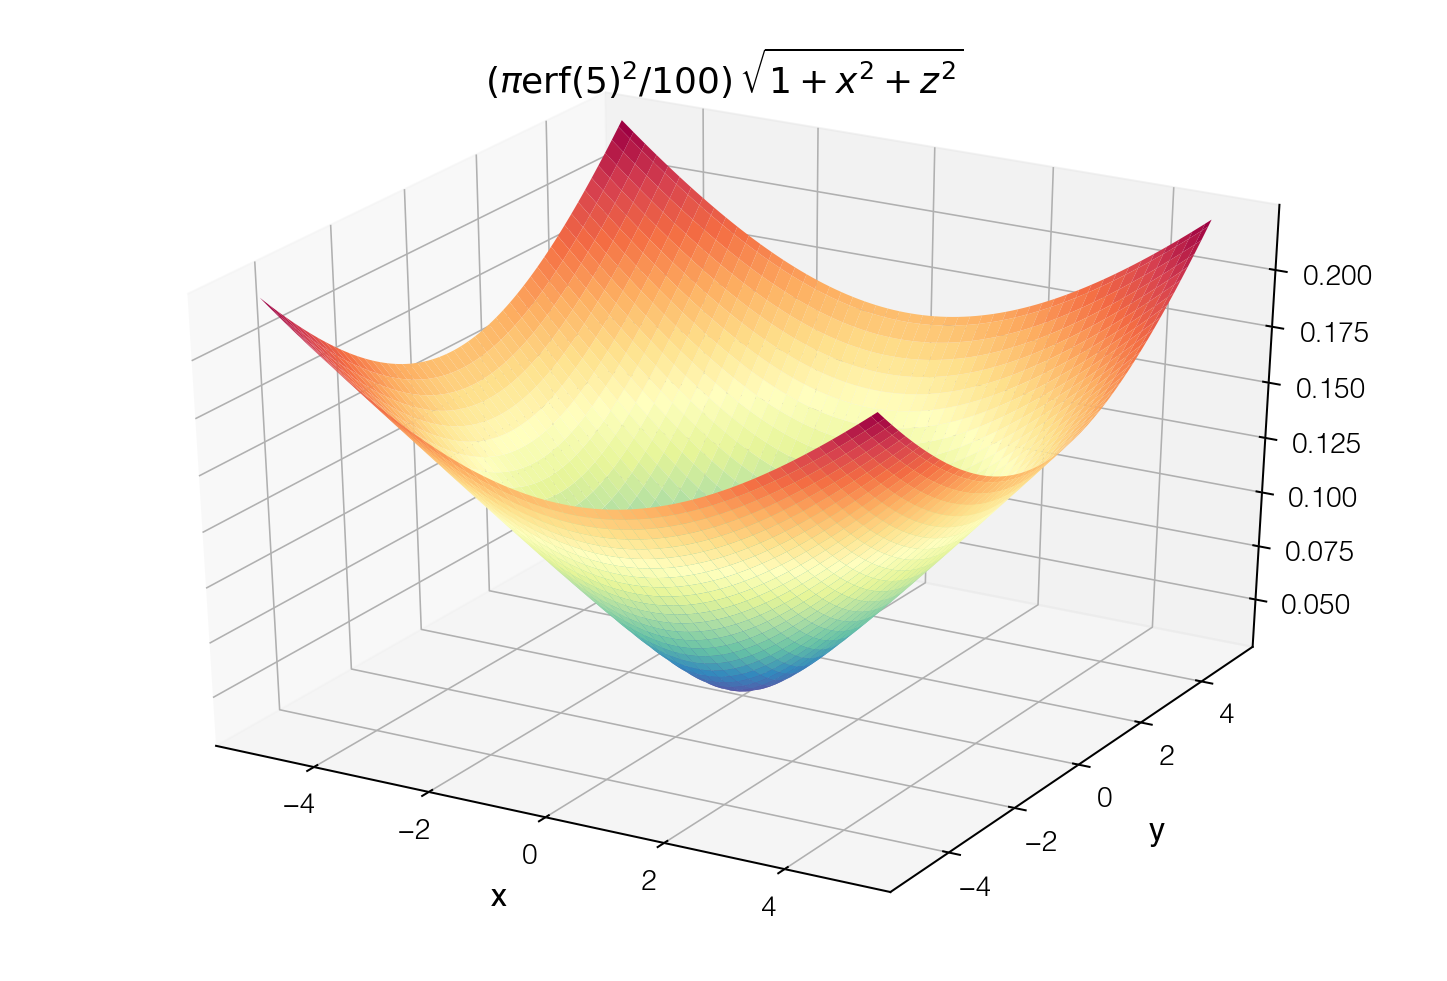

In [19]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
surf = ax.plot_surface(X, Y, (π*scipy.special.erf(5)**2/100)*np.sqrt(1+X**2+Y**2), rstride=2, cstride=2, 
                       cmap='Spectral_r', linewidth=0, antialiased=True)

ax.set_xlabel('x',labelpad=14)
ax.set_ylabel('y',labelpad=14)
ax.set_title('$(\pi\mathrm{erf}(5)^2/100)\, \sqrt{1+x^2+z^2}$')
ax.tick_params(axis='z', which='major', pad=10)

[t.label.set_fontsize(14) for caxis in [ax.xaxis, ax.yaxis, ax.zaxis] for t in caxis.get_major_ticks()];

### Question: How do we sample a generic probability distribution?  